In [3425]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3426]:
########## Block 1 ############## <-- Please refer this block number when you ask questions
import numpy as np
# package for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import scipy.stats as st
from scipy import optimize
from scipy.linalg import lapack

from pyDOE import lhs
import emcee

import time, os, pickle
# scikit-learn: machine learning in Python
# https://scikit-learn.org/stable/tutorial/basic/tutorial.html
# In this example, we are using the principal component analysis 
# and the Gaussian process regression as implemented in sklearn.
# Detailed documentation of these modules:
# Principal component analysis (PCA): 
# https://scikit-learn.org/stable/modules/decomposition.html
# Gaussian process gressor (GPR)):
# https://scikit-learn.org/stable/modules/gaussian_process.html
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from scipy.interpolate import interp1d
from scipy.integrate import quad
# suppression warning messages
import warnings
warnings.filterwarnings('ignore')
from glob import glob

# some plot settings, not important
fontsize  = 12
plt.rcdefaults()
plt.rcParams.update({
    'font.size': fontsize,
    'legend.fontsize': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.formatter.limits': (-5, 5),
    'axes.spines.top': True,
    'axes.spines.right': True,
    'legend.frameon': False,
    'image.cmap': 'Blues',
    'image.interpolation': 'none',
})


In [3427]:
# Genearte correlated random function as samples of (qhat/T^3)/mean
def Mean_f(x, mean):
    return mean*np.ones_like(x)
def Var_f(x, sigma, L, N, random_state):
    kernel = sigma**2 * kernels.RBF(length_scale=L)  
    GP = GPR(kernel=kernel)
    y = GP.sample_y(np.atleast_2d(x).T, n_samples=N, random_state=random_state)
    return y
def Get_f(x, mean, sigma, L, N, random_state=31415):
    # sigma_gaussian
    sigma_gaussian = np.sqrt(np.log(sigma**2+1))
    # get mean
    meanf = Mean_f(x, mean)
    # get Gaussian Varaiton
    varf = Var_f(x, sigma_gaussian, L, N, random_state=random_state)
    # convert Gaussian varation to positive definite log-normal fluctuation
    Pvarf = np.exp(
        varf-sigma_gaussian**2/2.)
    print(Pvarf[0].mean(), Pvarf[0].std())
    f = Pvarf.T*meanf
    return f, meanf, varf

0.9133115814319654 0.6748992986301335
1.0047880358715626 0.8384847723791581


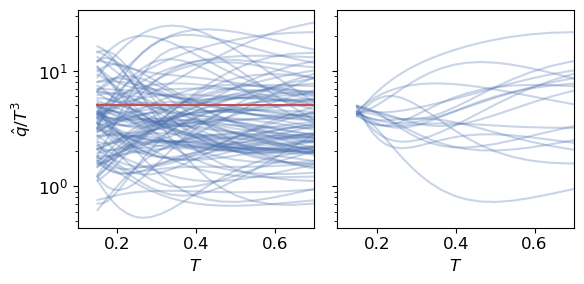

In [3428]:
fig, (ax, ax1) = plt.subplots(ncols=2,nrows=1,figsize=(6,3), sharex=True, sharey=True)
Tc = 0.15
lnT = np.linspace(np.log(Tc), np.log(5*Tc), 21)
T = np.exp(lnT)

#"""
qhats, mean_qhats, var_qhats = Get_f(lnT, 5, .8, np.log(2/1), 100)
qhats_prior, _, _ = Get_f(lnT, 5, .8, np.log(2/1), 10000)
with open("Parameters/qhat_design_tables.dat", 'w') as f:
    f.write( ("#"+"{:1.5e}\t"*len(T)+"\n").format(*T) )
    for it in qhats:
        f.write( ("{:1.5e}\t"*len(T)+"\n").format(*it) )
#"""
#qhats = np.loadtxt("Parameters/qhat_design_tables.dat")

_ = ax.plot(T, qhats.T, color='b', alpha=0.3)
_ = ax.plot(T, mean_qhats, 'r-')
q0 = qhats[:, 0]
q3 = qhats[:, 0]
cut = (q3<5) & (q3>4)
_ = ax1.plot(T, qhats[cut,:].T, color='b', alpha=0.3)
ax.set_xlim(0.1,.7)
#ax.set_ylim(0,20)
ax.set_xlabel(r"$T$")
ax1.set_xlabel(r"$T$")
ax.set_ylabel(r"$\hat{q}/T^3$")
ax.semilogy()
plt.tight_layout()
plt.savefig("qhat_sample.png")

In [3429]:
#for i, it in enumerate(qhats):
#    with open("Parameters/new-inputs/{:d}.dat".format(i), 'w') as f:
#        f.write("# T [GeV]\tqhat/T^3\n")
#        for iT, iQ in zip(T, it):
#            f.write( ("{:1.5e}\t{:1.5e}\n").format(iT,iQ) )

In [3430]:
Exps = ['AuAu200', 
        'PbPb2760', 
        #'PbPb5020'
       ]
def save_fig(fig_id):
    plt.tight_layout(True)
    plt.savefig(os.path.join(system_folder, fig_id) + ".png", format='png', dpi=300)
pTlow, pThigh = 10,100
Cens = {'AuAu200': ['0-10',
                    '10-20',
                    '20-30',
                    '30-40',
                    '40-50',
                    ],
        'PbPb2760': ['0-5',
                     '5-10',
                     '10-20',
                     '20-30',
                     '30-40',
                     '40-50',
                    ],
        'PbPb5020': [#'0-5',
                     #'5-10',
                     #'10-30',
                     #'30-50',
                    ]
       }

prefix = 'Results/'
system_folder = prefix+'-'.join(Exps)+'/'+'+'.join(Cens[Exps[1]])
print(system_folder)
os.makedirs(system_folder, exist_ok=True)

SimuFolder = './RAA-calculate-data/'
ExpFolder = './ExpData/'

Results/AuAu200-PbPb2760/0-5+5-10+10-20+20-30+30-40+40-50


In [3431]:
# load data
exp_x = {'AuAu200':{},
           'PbPb2760':{},
           'PbPb5020':{}
          }
exp_xl = {'AuAu200':{},
           'PbPb2760':{},
           'PbPb5020':{}
          }
exp_xh = {'AuAu200':{},
           'PbPb2760':{},
           'PbPb5020':{}
          }
exp_y = {'AuAu200':{},
           'PbPb2760':{},
           'PbPb5020':{}
          }
exp_stat = {'AuAu200':{},
           'PbPb2760':{},
           'PbPb5020':{}
          }
exp_sys = {'AuAu200':{},
           'PbPb2760':{},
           'PbPb5020':{}
          }
exp_sys2 = {'AuAu200':{},
           'PbPb2760':{},
           'PbPb5020':{}
          }

for exp in Exps:
    for cen in Cens[exp]:
        path = ExpFolder + '/' + exp\
            + '/' + cen + '.dat'
        if exp == 'AuAu200':
            x = np.loadtxt(path, usecols=0)
            cut = (pTlow<x) & (x<pThigh)
            x, xl, xh, y,\
            ystat, _, ysys, _, ysys2, _ = np.loadtxt(path, usecols=[0,1,2,3,4,5,6,7,8,9])[cut].T        
            exp_x[exp][cen] = x
            exp_xl[exp][cen] = xl
            exp_xh[exp][cen] = xh
            exp_y[exp][cen] = y
            exp_stat[exp][cen] = ystat
            exp_sys[exp][cen] = ysys
            exp_sys2[exp][cen] = ysys2
        elif exp == 'PbPb2760':
            x = np.loadtxt(path, usecols=0)
            cut = (pTlow<x) & (x<pThigh)
            x, xl, xh, y,\
            ystat, _, ysys, _ = np.loadtxt(path)[cut].T        
            exp_x[exp][cen] = x
            exp_xl[exp][cen] = xl
            exp_xh[exp][cen] = xh
            exp_y[exp][cen] = y
            exp_stat[exp][cen] = ystat
            exp_sys[exp][cen] = ystat*0
            exp_sys2[exp][cen] = ysys
        elif exp == 'PbPb5020':
            x = np.loadtxt(path, usecols=0)
            cut = (pTlow<x) & (x<pThigh)
            x, xl, xh, y,\
            ystat, _, ysys, _, ysys2, _, ysys3, _ = np.loadtxt(path)[cut].T        
            exp_x[exp][cen] = x
            exp_xl[exp][cen] = xl
            exp_xh[exp][cen] = xh
            exp_y[exp][cen] = y
            exp_stat[exp][cen] = ystat
            exp_sys[exp][cen] = ysys
            exp_sys2[exp][cen] = np.sqrt(ysys2**2 + ysys3**2)

        
def plot_exp(ax, x, xl, xh, y, stat, sys, sys2=None, c='k'):
    dx = (xh-xl)/2.
    ax.errorbar(x, y, xerr=dx, yerr=stat, fmt='.', color=c)
    for il, ih, yl, yh in zip(xl, xh, y-sys, y+sys):
        ax.fill_between([il,ih],[yl,yl],[yh,yh],alpha=1,edgecolor=c,facecolor='none')
    for il, ih, yl, yh in zip(xl, xh, y-sys2, y+sys2):
        ax.fill_between([il,ih],[yl,yl],[yh,yh],alpha=.3,color=c)

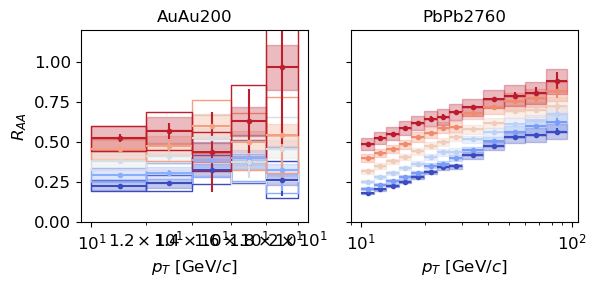

In [3432]:
# plot exp data
# plot the input of a certain design:
fig, axes = plt.subplots(1, len(Exps), 
                        figsize=(3*len(Exps),3),
                        sharey=True)
for exp, ax in zip(Exps, np.atleast_1d(axes)):
    for i, cen in enumerate(Cens[exp]):
        color = plt.cm.coolwarm(i/(len(Cens[exp])-.9))
        x = exp_x[exp][cen]
        xl = exp_xl[exp][cen]
        xh = exp_xh[exp][cen]
        y = exp_y[exp][cen]
        stat = exp_stat[exp][cen]
        sys = exp_sys[exp][cen]
        sys2 = exp_sys2[exp][cen] 
        plot_exp(ax, x, xl, xh, y, stat, sys, sys2, c=color)
        
    ax.semilogx()
    ax.set_title(exp)
    ax.set_ylim(0,1.2)
    if ax.is_first_col():
        ax.set_ylabel(r"$R_{AA}$")
    ax.set_xlabel(r"$p_T$ [GeV/$c$]")
save_fig("Exp")

In [3433]:
# define the design points
design = np.copy(qhats)
Ndesign = design.shape[0]
dimX = design.shape[1]
print("Number of design = ", Ndesign)
print("Inpout dimension = ", dimX)
# load calcualtion and contante them together
model_x = [ {'AuAu200':{},
           'PbPb2760':{},
           'PbPb5020':{}
          } for ip in range(Ndesign)]
model_y = [ {'AuAu200':{},
           'PbPb2760':{},
           'PbPb5020':{}
          } for ip in range(Ndesign)]
for ip in range(Ndesign):
    for exp in Exps:
        for cen in Cens[exp]:
            pattern = SimuFolder + '/' + exp\
                + '/RAA-' + cen \
                + '/*-q{:d}.dat'.format(ip)
            path = glob(pattern)[0]
            x, y = np.loadtxt(path).T
            calc = interp1d(x, y, fill_value='extrapolate')
            X = exp_x[exp][cen]
            model_x[ip][exp][cen] = X
            model_y[ip][exp][cen] = calc(X)

Number of design =  100
Inpout dimension =  21


In [3434]:
Npc=5
# Transform the design into the original space
SS  =  StandardScaler(copy=True)
pca = PCA(copy=True, whiten=True, svd_solver='full')
# Keep only the first `npc` principal components
pc_param_data = pca.fit_transform(SS.fit_transform(np.log(design))) [:,:Npc]

# The transformation matrix from PC to Physical space
inverse_param_matrix = pca.components_ * np.sqrt(pca.explained_variance_[:, np.newaxis]) * SS.scale_ 
inverse_param_matrix = inverse_param_matrix[:Npc,:] # Z --> [Nch, v2]

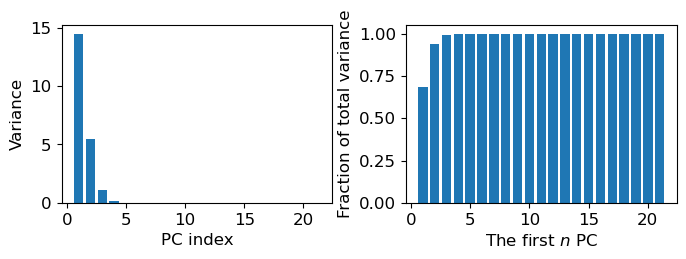

In [3435]:
#### Block 14 #### Please refer to this number in your questions
# print the explained raito of variance
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,2.6))
#importance = pca_analysis.explained_variance_
importance = pca.explained_variance_
cumulateive_importance = np.cumsum(importance)/np.sum(importance)
idx = np.arange(1,1+len(importance))
ax1.bar(idx,importance)
ax1.set_xlabel("PC index")
ax1.set_ylabel("Variance")
ax2.bar(idx,cumulateive_importance)
ax2.set_xlabel(r"The first $n$ PC")
ax2.set_ylabel("Fraction of total variance")
save_fig("Param_PC")

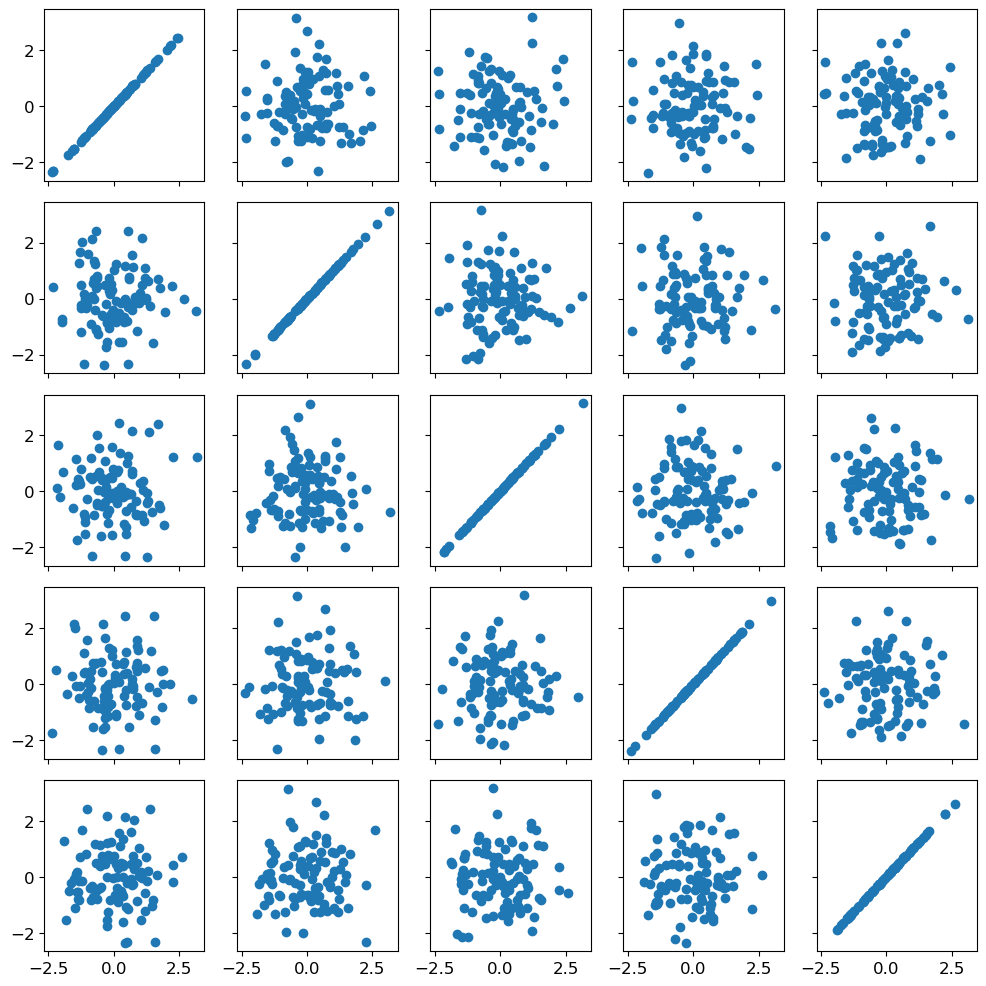

In [3436]:
fig, axes = plt.subplots(Npc, Npc, figsize=(Npc*2, Npc*2), sharex=True, sharey=True)
for i in range(Npc):
    for j in range(Npc):
        ix = pc_param_data[:,i]
        iy = pc_param_data[:,j]
        axes[i,j].scatter(ix,iy)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("param_PC_diag")

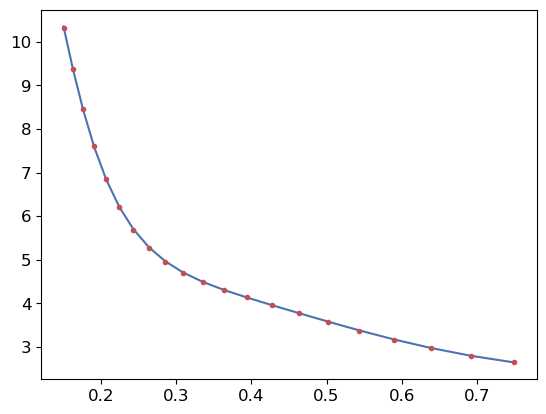

In [3437]:
j = 20
p = pc_param_data[j] 
res = p @ inverse_param_matrix + SS.mean_
res = np.exp(res)
plt.plot(T, res,'b-')
plt.plot(T, design[j],'r.')

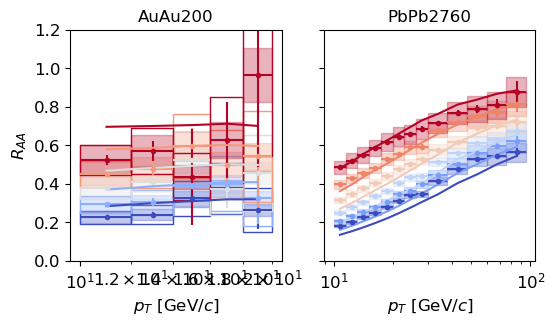

In [3438]:
# plot the input of a certain design:
fig, axes = plt.subplots(1, len(Exps), 
                        figsize=(3*len(Exps),3),
                        sharey=True)
icheck = 23
for exp, ax in zip(Exps, np.atleast_1d(axes)):
    for i, cen in enumerate(Cens[exp]):
        pattern = SimuFolder + '/' + exp\
                + '/RAA-' + cen \
                + '/*-q{:d}.dat'.format(icheck)
        path = glob(pattern)[0]
        color = plt.cm.coolwarm(i/(len(Cens[exp])-.99))
        x, y = np.loadtxt(path).T
        x = model_x[icheck][exp][cen]
        y = model_y[icheck][exp][cen]
        ax.plot(x,y, color=color)

        x = exp_x[exp][cen]
        xl = exp_xl[exp][cen]
        xh = exp_xh[exp][cen]
        y = exp_y[exp][cen]
        stat = exp_stat[exp][cen]
        sys = exp_sys[exp][cen] 
        sys2 = exp_sys2[exp][cen] 
        plot_exp(ax, x, xl, xh, y, stat, sys, sys2, c=color)
        
    ax.semilogx()
    ax.set_title(exp)
    ax.set_ylim(0,1.2)
    if ax.is_first_col():
        ax.set_ylabel(r"$R_{AA}$")
    ax.set_xlabel(r"$p_T$ [GeV/$c$]")


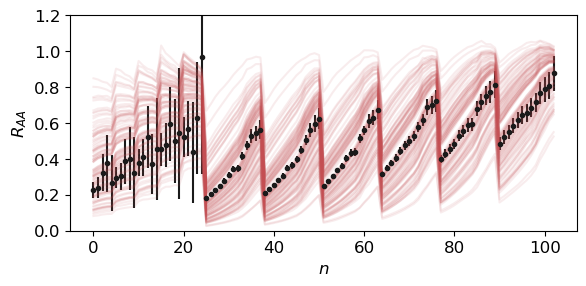

In [3439]:
# plot all calcualtions and concate them to a single Ndesign by M matrix
fig, ax = plt.subplots(1,1,figsize=(3*len(Exps),3))
model_y_c = []
icheck = 0
for i in range(Ndesign):
    it = []
    for exp in Exps:
        for cen in Cens[exp]:
            color = plt.cm.coolwarm(i/len(Cens[exp]))
            x = model_x[i][exp][cen]
            y = model_y[i][exp][cen]
            it.append(y)
    it = np.concatenate(it)
    model_y_c.append(it)
    ax.plot(np.arange(len(it)),it,color='r', alpha=.1)
model_y_c = np.array(model_y_c)
y_exp = []
# uncorr
y_local = []
for exp in Exps:
    for cen in Cens[exp]:
        y = exp_y[exp][cen]
        stat = exp_stat[exp][cen]
        sys = exp_sys[exp][cen]
        y_exp.append(y)
        y_local.append(np.sqrt(stat**2+sys**2) )
y_exp = np.concatenate(y_exp)
y_local = np.concatenate(y_local)
y_exp_variance = np.diag(y_local**2) 

# corr
il=0
for exp in Exps:
    for cen in Cens[exp]:    
        sys2 = exp_sys2[exp][cen]
        ih = il+len(sys2)
        y_exp_variance[il:ih, il:ih] += np.outer(sys2, sys2)
        il = np.copy(ih)
        


ax.errorbar(np.arange(len(y_exp)), y_exp, yerr=np.diag(y_exp_variance)**.5, fmt='k.')
ax.set_ylim(0,1.2)
ax.set_ylabel(r"$R_{AA}$")
ax.set_xlabel(r"$n$")
save_fig("Prior_vs_data")

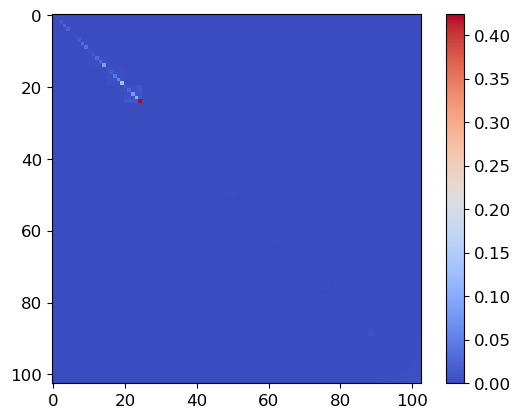

In [3440]:
plt.imshow(y_exp_variance, cmap=plt.cm.coolwarm, vmin=0)
plt.colorbar()

In [3441]:
Npc2 = 4
# Transform the design into the original space
SS2  =  StandardScaler(copy=True)
pca2 = PCA(copy=True, whiten=True, svd_solver='full')
# Keep only the first `npc` principal components
pc_model_data = pca2.fit_transform(SS2.fit_transform(model_y_c)) [:,:Npc2]

# The transformation matrix from PC to Physical space
inverse_model_matrix = pca2.components_ * np.sqrt(pca2.explained_variance_[:, np.newaxis]) * SS2.scale_ 
inverse_model_matrix = inverse_model_matrix[:Npc2,:] # Z --> [Nch, v2]
print(inverse_model_matrix.shape)

(4, 103)


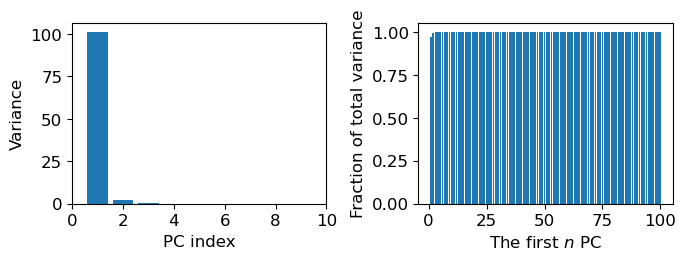

In [3442]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,2.6))
#importance = pca_analysis.explained_variance_
importance = pca2.explained_variance_
cumulateive_importance = np.cumsum(importance)/np.sum(importance)
idx = np.arange(1,1+len(importance))
ax1.bar(idx,importance)
ax1.set_xlabel("PC index")
ax1.set_ylabel("Variance")
ax1.set_xlim(0,10)
ax2.bar(idx,cumulateive_importance)
ax2.set_xlabel(r"The first $n$ PC")
ax2.set_ylabel("Fraction of total variance")
save_fig("Obs_PCA")

In [3443]:
DIM = np.copy(Npc)
design_min = -np.ones(DIM)*2.5
design_max = np.ones(DIM)*2.5
design_ptp = design_max - design_min

In [3444]:
# Traning GP:
#### Block 15 #### Please refer to this number in your questions

overide = True
EMU = "emulators.dat"
if (os.path.exists(EMU)) and (overide==False):
    print('Saved emulators exists and overide is prohibited')
    with open(EMU,"rb") as f:
        Emulators=pickle.load(f)
else:
    Emulators = []
    for i in range(Npc2):
        start_time = time.time()
        kernel = 1*kernels.RBF(length_scale=design_ptp,
                          length_scale_bounds=np.outer(design_ptp, (1e-1, 1e2)))\
               +   kernels.WhiteKernel(noise_level=.1, 
                           noise_level_bounds=(1e-4, 1e2))
        print("-----------------")
        print("Training PC #",i+1)
        GPR=gpr(kernel=kernel,n_restarts_optimizer=5)
        GPR.fit(pc_param_data, pc_model_data[:,i].reshape(-1,1))
        print('GPR score: {:1.3f}'.format(GPR.score(pc_param_data, pc_model_data[:,i])) )
        print("time: {:1.3f} seconds".format(time.time() - start_time))
        Emulators.append(GPR)

if (overide==True) or not (os.path.exists(EMU)):
    with open(EMU, "wb") as f:
        pickle.dump(Emulators,f)
        

-----------------
Training PC # 1
GPR score: 1.000
time: 0.394 seconds
-----------------
Training PC # 2
GPR score: 1.000
time: 0.385 seconds
-----------------
Training PC # 3
GPR score: 1.000
time: 0.329 seconds
-----------------
Training PC # 4
GPR score: 0.999
time: 0.621 seconds


In [3445]:
#### Block 16 #### Please refer to this number in your questions

# This function takes model parmaeters, 
# 1. gets GP emulator prediction on principal components
# 2. inverse transform of PCA+standard scaler
# 3. inverse transform the sqrt(*) non-linear transformation that we add by hand
def predict_observables(theta, extra_std=.05):
    mean = []
    std = []
    for i in range(Npc2):
        mn, s = Emulators[i].predict([theta], return_std=True)
        mean.append(mn[0])
        std.append(s[0])
    mean = np.array(mean)
    variance_matrix = np.diag(np.array(std)**2+extra_std**2)
    inverse_transformed_mean = mean.reshape(-1,Npc2)@inverse_model_matrix + SS2.mean_
    inverse_transformed_variance = np.matmul(np.matmul(inverse_model_matrix.T, variance_matrix), inverse_model_matrix)
    return inverse_transformed_mean[0], inverse_transformed_variance

(0.0, 1.2)

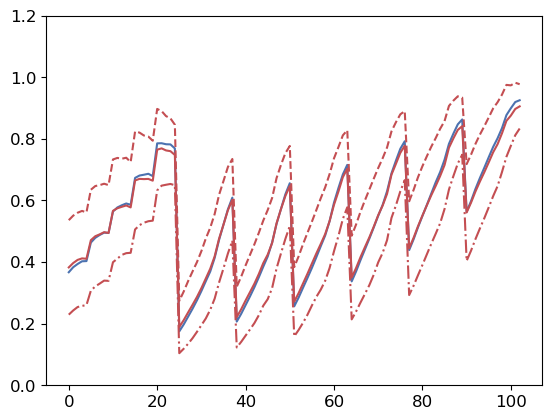

In [3446]:
ic1, ic2 = 3, 13
y, e = predict_observables(.5*(pc_param_data[ic1]+pc_param_data[ic2]))
plt.plot(y,'b-')
plt.plot((model_y_c[ic1]+model_y_c[ic2])/2.,'r-')
plt.plot(model_y_c[ic1],'r--')
plt.plot(model_y_c[ic2],'r-.')
plt.ylim(0,1.2)

In [3474]:
#### Block 20 #### Please refer to this number in your questions
sigma0 = 0.025

def log_prior(X):
    if (X[:-1]**2).sum() > 6.25 or X[-1]<1e-3 or X[-1]>0.5:
        return -np.inf
    else:
        sigma = X[-1]
        return -.5*(X[:-1]**2).sum() + np.log(sigma) - sigma/sigma0


#### Block 21 #### Please refer to this number in your questions
def mvn_loglike(y, cov):# y = y_pred - y_exp, cov = exp + emulator
    """
    Evaluate the multivariate-normal log-likelihood for difference vector `y`
    and covariance matrix `cov`:

        log_p = -1/2*[(y^T).(C^-1).y + log(det(C))] + const.

    The likelihood is NOT NORMALIZED, since this does not affect MCMC.  The
    normalization const = -n/2*log(2*pi), where n is the dimensionality.

    Arguments `y` and `cov` MUST be np.arrays with dtype == float64 and shapes
    (n) and (n, n), respectively.  These requirements are NOT CHECKED.

    The calculation follows algorithm 2.1 in Rasmussen and Williams (Gaussian
    Processes for Machine Learning).

    """
    # Compute the Cholesky decomposition of the covariance.
    # Use bare LAPACK function to avoid scipy.linalg wrapper overhead.
    L, info = lapack.dpotrf(cov, clean=False)

    if info < 0:
        raise ValueError(
            'lapack dpotrf error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
    elif info < 0:
        raise np.linalg.LinAlgError(
            'lapack dpotrf error: '
            'the leading minor of order {} is not positive definite'
            .format(info)
        )

    # Solve for alpha = cov^-1.y using the Cholesky decomp.
    alpha, info = lapack.dpotrs(L, y)

    if info != 0:
        raise ValueError(
            'lapack dpotrs error: '
            'the {}-th argument had an illegal value'.format(-info)
         )

    if np.all(L.diagonal()>0):
        return -.5*np.dot(y, alpha) - np.log(L.diagonal()).sum()
    else:
        return -.5*np.dot(y, alpha) - np.log(np.abs(L.diagonal())).sum()
        print(L.diagonal())
        raise ValueError(
            'L has negative values on diagonal {}'.format(L.diagonal())
        )
        
#### Block 22 #### Please refer to this number in your questions
# Covariance truncation error from PC is not yet included
def log_posterior(model_parameters):
    mean, pred_var = predict_observables(model_parameters[:-1], extra_std=model_parameters[-1])
    delta_y = mean - y_exp
    total_var = pred_var + y_exp_variance
    return log_prior(model_parameters) + mvn_loglike(delta_y, total_var)

In [3475]:
#### Block 23 #### Please refer to this number in your questions

DIM_ = DIM+1
design_min_ = np.array(list(design_min)+[0])
design_max_ = np.array(list(design_max)+[0.5])
ptp_ = design_max_ - design_min_

do_mcmc = True
nwalkers = 10*DIM_  # number of MCMC walkers
nburn = 500 # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take


if do_mcmc==True:

    starting_guesses = design_min_+ptp_*.4 + ptp_*.2 * np.random.rand(nwalkers, DIM_)

    print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
    sampler = emcee.EnsembleSampler(nwalkers, DIM_, log_posterior)
    print('burn in sampling started')    
    pos = sampler.run_mcmc(starting_guesses, nburn, progress=True, store=True)
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                    np.mean(sampler.acceptance_fraction), nwalkers*nburn))
    print('Burn in completed.')
    print("Now running the samples")
    sampler.run_mcmc(initial_state=None, nsteps=nsteps, progress=True, tune=False)  
    print("Mean acceptance fraction: {0:.3f} (in total {1} steps)".format(
                    np.mean(sampler.acceptance_fraction), nwalkers*nsteps))

    samples = sampler.get_chain(flat=True, discard=nburn)
    samples_df = pd.DataFrame(samples)
    samples_df.to_csv(system_folder+"/chain.dat", index=False)
else:

    print('Loading chain from disk')
    samples_df=pd.read_csv(system_folder+"/chain.dat")
    samples= samples_df.values
samples_df.head()

  0%|          | 0/500 [00:00<?, ?it/s]

MCMC sampling using emcee (affine-invariant ensamble sampler) with 60 walkers
burn in sampling started


  0%|          | 3/2000 [00:00<01:34, 21.22it/s]

Mean acceptance fraction: 0.424 (in total 30000 steps)
Burn in completed.
Now running the samples


100%|██████████| 2000/2000 [01:42<00:00, 19.43it/s]


Mean acceptance fraction: 0.415 (in total 120000 steps)


,0,1,2,3,4,5
0,0.075444,0.920736,0.342014,-0.810583,0.331072,0.217517
1,-0.464884,2.351943,0.550951,0.216844,-0.052755,0.382716
2,0.228331,0.445645,-0.667457,0.481863,-0.508284,0.232656
3,0.140773,0.570943,-0.024339,-1.069403,-0.271530,0.328157
4,-0.155007,-0.514709,-1.883792,-0.130969,-0.246327,0.285249


[]

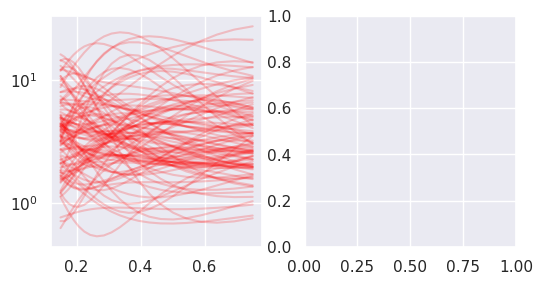

In [3476]:
fig, axes = plt.subplots(1,2,figsize=(6,3))
ax = axes[0]
for iy in design:
    ax.plot(T, iy,color='red',alpha=.2)
ax.semilogy()

In [3477]:
import seaborn as sns
sns.set("notebook")
sns.color_palette('bright')

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

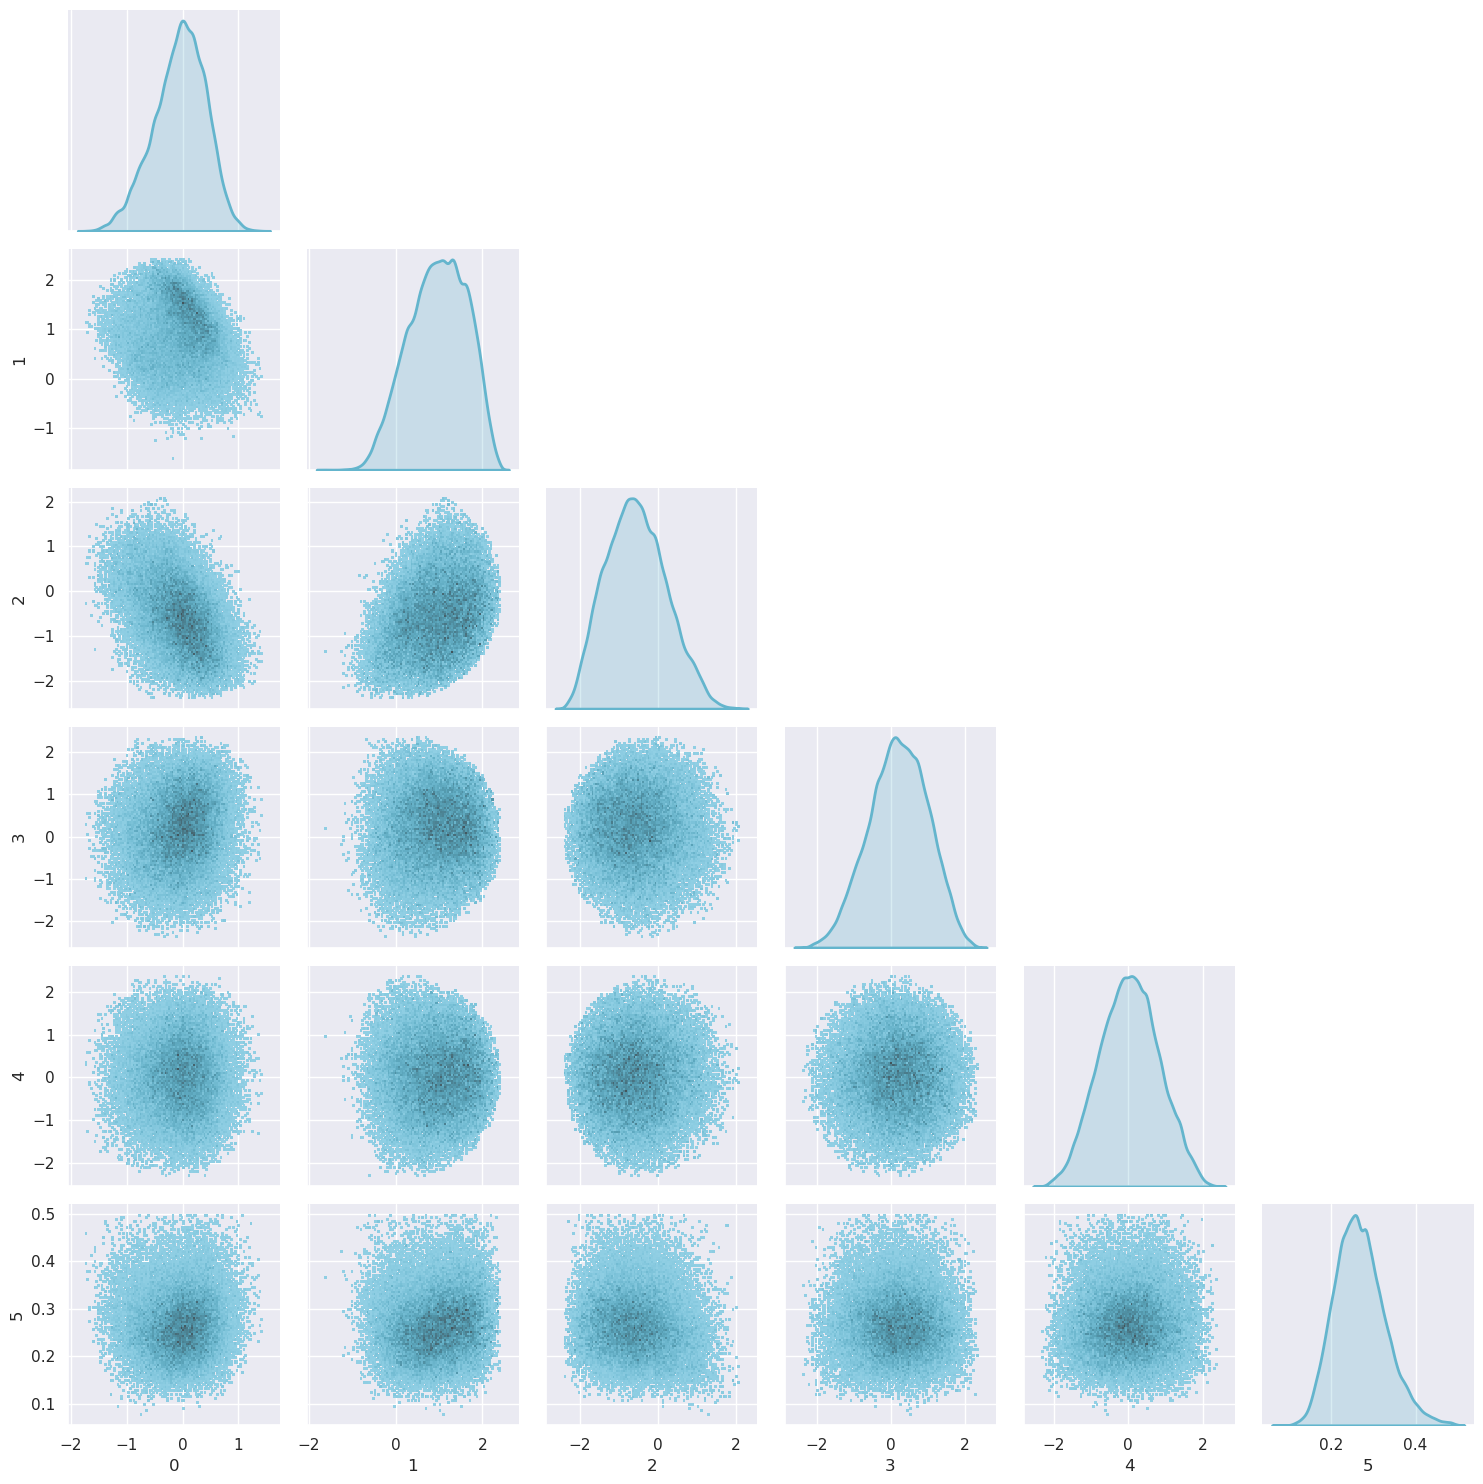

In [3478]:
#### Block 25 #### Please refer to this number in your questions
g = sns.PairGrid(samples_df.iloc[:,:], corner=True, diag_sharey=False)
g.map_lower(sns.histplot, bins=100, color=sns.color_palette()[9])
g.map_diag(sns.kdeplot, linewidth=2, shade=True, color=sns.color_palette()[-1])

plt.tight_layout()


In [3479]:
def PC2qhat(p):
    res = p @ inverse_param_matrix + SS.mean_
    return np.exp(res)

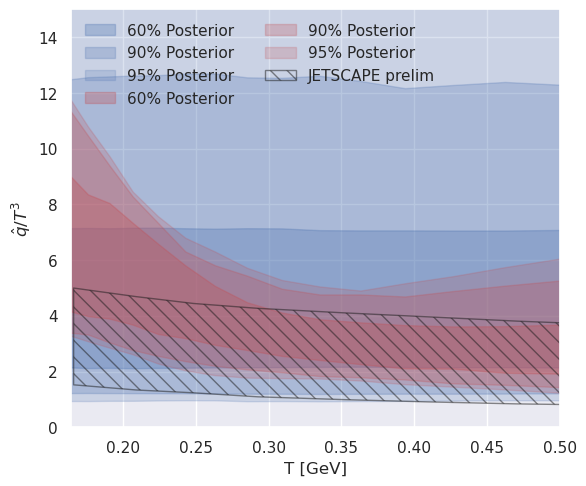

In [3480]:
#### Block 26 #### Please refer to this number in your questions
Nsamples = 1000
Nthin = samples_df.size//Nsamples

posterior_qhat = np.array([
        PC2qhat(it[:-1]) for it in samples_df.iloc[::Nthin,:].values
])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5), sharex=False, sharey=False, constrained_layout=True)
# plot posterior, display 30%, 60%, and 90% credible limits
CLbins = [60,90, 95]
for CL, opacity in zip(CLbins, [.3,.25,.2]):
    lower, upper = np.percentile(qhats_prior, [50-CL/2., 50+CL/2.], axis=0)
    ax.fill_between(T,lower, upper,color=sns.color_palette()[0], alpha=opacity, label='{:d}% Posterior'.format(CL))
    

# plot posterior, display 30%, 60%, and 90% credible limits
CLbins = [60,90, 95]
for CL, opacity in zip(CLbins, [.3,.25,.2]):
    lower, upper = np.percentile(posterior_qhat, [50-CL/2., 50+CL/2.], axis=0)
    ax.fill_between(T,lower, upper,color=sns.color_palette()[3], alpha=opacity, label='{:d}% Posterior'.format(CL))
    
Tj, qjl, qjh = np.loadtxt("./JETSCAPE_prelim.dat").T
ax.fill_between(Tj, qjl, qjh, edgecolor='k', facecolor='none', label='JETSCAPE prelim', hatch='\\\\', alpha=.5)

ax.set_ylim(0,15)
ax.set_xlim(.164,.5)
ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('T [GeV]')
ax.set_ylabel('$\hat{q}/T^3$')
save_fig("qhat")

In [3481]:
obs = np.array([
        predict_observables(it[:-1])[0] for it in samples_df.iloc[::Nthin,:].values
])

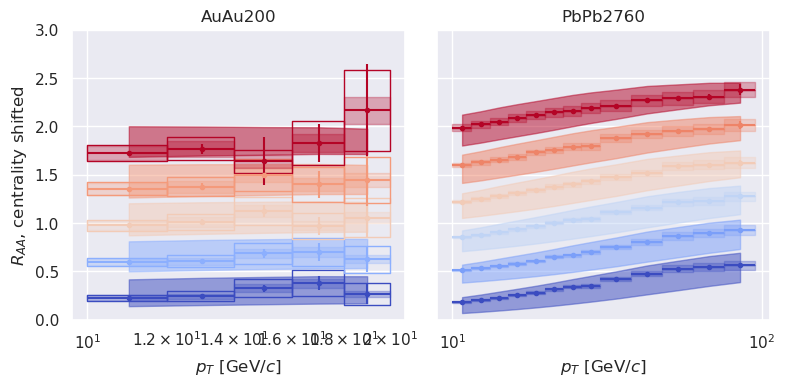

In [3482]:
# plot the input of a certain design:
fig, axes = plt.subplots(1, len(Exps), 
                        figsize=(4*len(Exps),4),
                        sharey=True)
il=0
ih=0
for exp, ax in zip(Exps, np.atleast_1d(axes)):
    for i, cen in enumerate(Cens[exp]):
        shift = i*.3
        ing = i/(len(Cens[exp])-.99)
        if np.abs(ing-.5)<.05:
            ing=.6
        color = plt.cm.coolwarm(ing)
        x = exp_x[exp][cen]
        xl = exp_xl[exp][cen]
        xh = exp_xh[exp][cen]
        y = exp_y[exp][cen]
        stat = exp_stat[exp][cen]
        sys = exp_sys[exp][cen] 
        sys2 = exp_sys2[exp][cen] 
        ih = il+len(x)
        low = np.percentile(obs[:,il:ih], 5, axis=0)
        high = np.percentile(obs[:,il:ih], 95, axis=0)
        ax.fill_between(x, low+shift, high+shift, color=color, alpha=0.5)
        plot_exp(ax, x, xl, xh, y+shift, stat, sys, sys2, c=color)
        il=np.copy(ih)
        
    ax.semilogx()
    ax.set_title(exp)
    ax.set_ylim(0,3)
    if ax.is_first_col():
        ax.set_ylabel(r"$R_{AA}$, centrality shifted")
    ax.set_xlabel(r"$p_T$ [GeV/$c$]")
save_fig("obs")